## Fit IGM nuisance parameters to eBOSS P1D, one z at a time

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
import matplotlib.pyplot as plt

# our own modules
from lace.emulator.emulator_manager import set_emulator
from cup1d.p1ds import (
    data_Chabanier2019,
    data_Karacayli2022
)
from cup1d.likelihood import lya_theory, likelihood, emcee_sampler
from cup1d.likelihood.sampler_pipeline import set_archive, set_P1D, set_P1D_hires, set_fid_cosmo, set_like
from cup1d.likelihood.input_pipeline import Args

In [2]:
# args = Args(emulator_label="Pedersen21")
args = Args(emulator_label="Pedersen23_ext8", training_set="Cabayol23")
# args = Args(emulator_label="Cabayol23+", training_set="Cabayol23")
# args = Args(emulator_label="Nyx_alphap", training_set="Nyx23_Oct2023")

In [3]:
args.data_label = "Chabanier19"
args.data_label_hires = "Karacayli22"
args.add_hires = True
args.add_metals = True

In [26]:
z_min=2.2
z_max=4.4
zs=np.arange(z_min,z_max+0.01,0.2)
Nz=len(zs)
print(Nz, zs)

12 [2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


### Set archive

In [27]:
archive = set_archive(args.training_set)

### Set emulator

In [28]:
emulator = set_emulator(
    emulator_label=args.emulator_label,
    archive=archive,
)

Use custom archive provided by the user
Select emulator in Pedersen23_ext8
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 8 Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


 /Users/afont/Codes/igmhub/LaCE/lace/emulator/gp_emulator.py:266: UserWarning:Enforce average=both in training of GP emulator
 /Users/afont/Codes/igmhub/LaCE/lace/emulator/gp_emulator.py:268: UserWarning:Enforce val_scalinge=1 in training of GP emulator


Training GP on 330 points
GPs optimised in 0.19 seconds


 /opt/miniconda3/envs/cup1d/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


### Set fiducial cosmology

In [29]:
cosmo_fid = set_fid_cosmo(cosmo_label=args.cosmo_label)

### Set likelihoods (one per redshift bin)

In [30]:
def get_onez_likelihood(z):
    data, true_sim_igm = set_P1D(
        archive,
        emulator,
        args.data_label,
        cosmo_fid,
        cov_label=args.cov_label,
        apply_smoothing=False,
        z_min=z-0.01,
        z_max=z+0.01,
    )

    extra_data = set_P1D_hires(
        archive,
        emulator,
        cosmo_fid,
        args.data_label_hires,
        args.cov_label_hires,
        apply_smoothing=False,
        z_min=z-0.01,
        z_max=z+0.01,
    )
    
    like = set_like(
        emulator,
        data,
        extra_data,
        true_sim_igm,
        args.igm_label,
        1,
        cosmo_fid,
        fix_cosmo=True,
        add_metals=args.add_metals,
    )
    
    return like

In [31]:
allz_runs=[]
for iz,z in enumerate(zs):
    like = get_onez_likelihood(z)
    onez_run={'z':z, 'like':like}
    allz_runs.append(onez_run)

Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Us

In [32]:
if False:
#for iz in range(Nz):
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=False)
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False)
    plt.xscale('log')

In [33]:
def fit_onez_likelihood(like):
    def log_prob(theta):
        return log_prob.sampler.like.log_prob_and_blobs(theta)

    def set_log_prob(sampler):
        log_prob.sampler = sampler
        return log_prob

    sampler = emcee_sampler.EmceeSampler(
        like=like,
        rootdir=".",
        save_chain=False,
        nburnin=args.n_burn_in,
        nsteps=args.n_steps,
        parallel=args.parallel,
        explore=args.explore,
        fix_cosmology=args.fix_cosmo,
    )
    _log_prob = set_log_prob(sampler)
    
#    %%time
#    _emcee_sam = sampler.run_sampler(log_func=_log_prob)

    npar=len(like.free_params)
    sampler.run_minimizer(log_func=_log_prob,p0=0.5*np.ones(npar))
    
    return sampler

In [34]:
for iz in range(Nz):
    sampler = fit_onez_likelihood(allz_runs[iz]['like'])
    allz_runs[iz]['sampler']=sampler

Created directory: ./chain_24
setup with  1  ranks,  201  walkers, and  0  steps
combined steps  0 (should be close to  0 )
Minimization improved: -75.6420519603191 2.1525403659825955
MLE: {'$\\mathrm{ln}\\,\\tau_0$': 0.2733687667677728, '$\\mathrm{ln}\\,\\sigma^T_0$': 0.10681434982297588, '$\\mathrm{ln}\\,\\gamma_0$': 0.18919520531322576, '$\\mathrm{ln}\\,k^F_0$': -0.21107767356852514, '$\\mathrm{ln}\\,f^{SiIII}_0$': -5.296284574094358, '$\\Delta^2_\\star$': 0.3466382078507112, '$n_\\star$': -2.2970308574311, '$f_\\star$': -0.21630395006182207, '$g_\\star$': 0.9813418279605083, '$\\alpha_\\star$': 0.9677508029137881, '$H_0$': 67.0}
Created directory: ./chain_25
setup with  1  ranks,  201  walkers, and  0  steps
combined steps  0 (should be close to  0 )
Minimization improved: -90.52430479570742 19.869032687724754
MLE: {'$\\mathrm{ln}\\,\\tau_0$': 0.11211242705523605, '$\\mathrm{ln}\\,\\sigma^T_0$': 0.11188621259318676, '$\\mathrm{ln}\\,\\gamma_0$': 0.20738701676696603, '$\\mathrm{ln}\

In [35]:
if False:
#for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    
    best_fit_values=sampler.mle_cube
    npar=len(best_fit_values)
    chi2=sampler.like.get_chi2(values=best_fit_values)
    dof=len(sampler.like.data.k_kms[0])-npar
    f, ax = plt.subplots()

    sampler.like.plot_p1d(residuals=False,values=best_fit_values)
#    allz_runs[iz]['like'].plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    sampler.like.extra_p1d_like.plot_p1d(residuals=False,values=best_fit_values)
#    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    plt.xscale('log')
    plt.text(0.5,0.1,'chi2={:.2f}, dof={}'.format(chi2,dof),transform=ax.transAxes)

    plt.savefig('p1d_eboss_highres_z{}.png'.format(zs[iz]))

In [36]:
if False:
#for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=True,values=sampler.mle_cube)
#    allz_runs[iz]['like'].plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=True,values=sampler.mle_cube)
#    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False,values=0.5*np.ones_like(sampler.mle_cube))
    plt.xscale('log')
    plt.savefig('res_p1d_eboss_highres_z{}.png'.format(zs[iz]))

### Plot P1D measurements and fiducial theory models (eBOSS only)

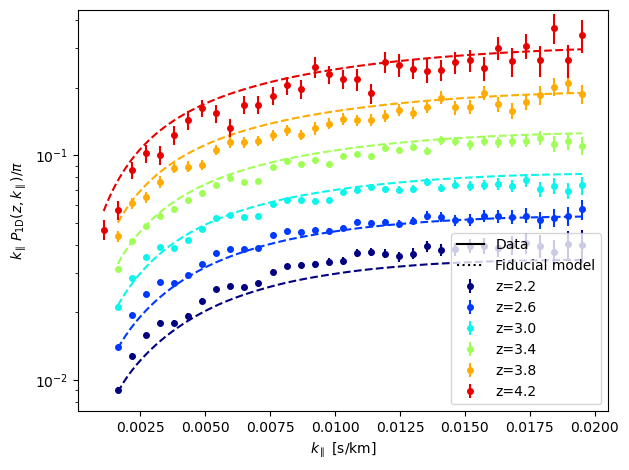

In [37]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
for iz in range(0,Nz,2):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    values=0.5*np.ones_like(values)
    like=sampler.like
    if True:
        # get measured bins from data
        k_kms = like.data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)

        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = like.data.get_Pk_iz(0)
        p1d_cov = like.data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Fiducial model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(min(k_kms) - 0.001, max(k_kms) + 0.001)
plt.tight_layout()
plt.savefig('p1d_eboss_fiducial.png')

### Plot P1D measurements and fiducial theory models (include high-res)

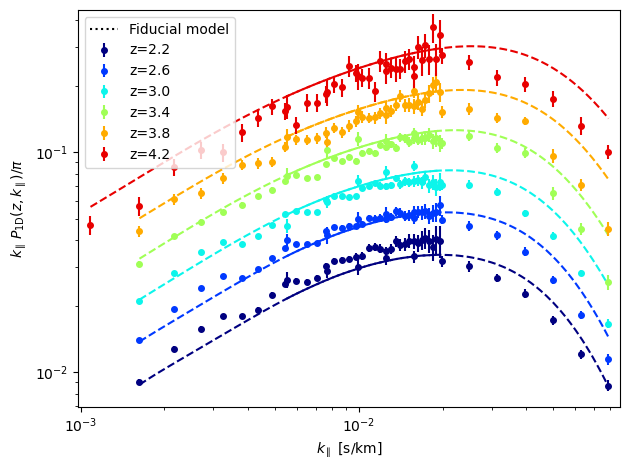

In [51]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
xmin = ymin
xmax = ymax
for iz in range(0,Nz,2):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    values=0.5*np.ones_like(values)
    like=sampler.like
    for highres in [False, True]:
        if highres:
            data = like.extra_p1d_like.data
            label = None
        else:
            data = like.data
            label="z=" + str(np.round(z, 2))
        # get measured bins from data
        k_kms = data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)

        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = data.get_Pk_iz(0)
        p1d_cov = data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label=label,
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label=label,
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))
            xmin = min(xmin, min(k_kms))
            xmax = max(xmax, max(k_kms))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

#plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Fiducial model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(0.9*xmin, 1.1*xmax)
plt.xscale('log')
plt.tight_layout()
plt.savefig('p1d_eboss_highres_fiducial.png')

### Plot P1D measurements and best-fit theory models (only eBOSS)

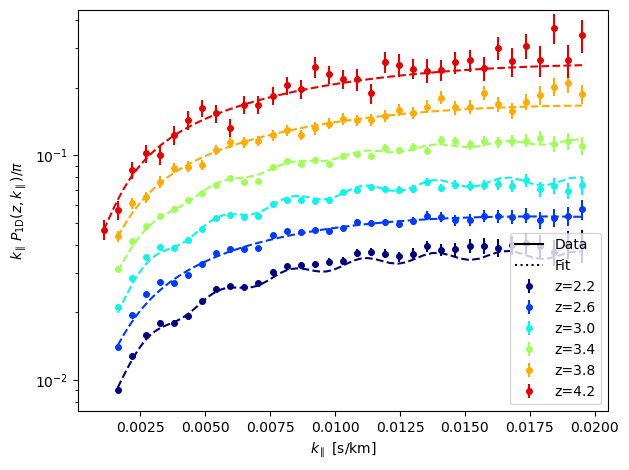

In [39]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
for iz in range(0,Nz,2):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    like=sampler.like
    if True:
        # get measured bins from data
        k_kms = like.data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)



        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = like.data.get_Pk_iz(0)
        p1d_cov = like.data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Fit", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(min(k_kms) - 0.001, max(k_kms) + 0.001)
plt.tight_layout()
plt.savefig('p1d_eboss_bestfit.png')

### Plot P1D measurements and best-fit theory models (include high-res)

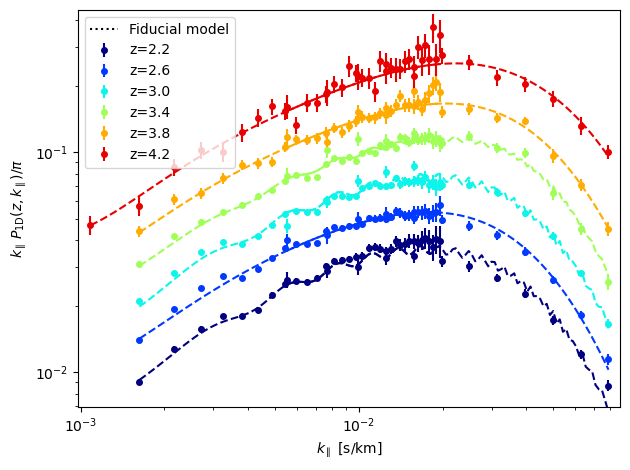

In [53]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
xmin = ymin
xmax = ymax
for iz in range(0,Nz,2):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    #values=0.5*np.ones_like(values)
    like=sampler.like
    for highres in [False, True]:
        if highres:
            data = like.extra_p1d_like.data
            label = None
        else:
            data = like.data
            label="z=" + str(np.round(z, 2))
        # get measured bins from data
        k_kms = data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)

        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = data.get_Pk_iz(0)
        p1d_cov = data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label=label,
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label=label,
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))
            xmin = min(xmin, min(k_kms))
            xmax = max(xmax, max(k_kms))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

#plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Fiducial model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(0.9*xmin, 1.1*xmax)
plt.xscale('log')
plt.tight_layout()
plt.savefig('p1d_eboss_highres_bestfit.png')

In [40]:
a=3